<a href="https://colab.research.google.com/github/wose70/HDB_Rental/blob/main/DL_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

latitude     153
longitude    153
dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
3401/3401 - 13s - 4ms/step - loss: 526098.7500 - mae: 483.3506 - mse: 526098.7500 - val_loss: 277653.5625 - val_mae: 402.5428 - val_mse: 277653.5625
Epoch 2/50
3401/3401 - 11s - 3ms/step - loss: 270595.7500 - mae: 395.6477 - mse: 270595.7500 - val_loss: 271429.7188 - val_mae: 397.1140 - val_mse: 271429.7188
Epoch 3/50
3401/3401 - 20s - 6ms/step - loss: 268398.0000 - mae: 393.8626 - mse: 268398.0000 - val_loss: 268514.8438 - val_mae: 395.0658 - val_mse: 268514.8438
Epoch 4/50
3401/3401 - 20s - 6ms/step - loss: 267246.5625 - mae: 392.8657 - mse: 267246.5625 - val_loss: 268279.0000 - val_mae: 393.0072 - val_mse: 268279.0000
Epoch 5/50
3401/3401 - 11s - 3ms/step - loss: 266400.2188 - mae: 392.1381 - mse: 266400.2188 - val_loss: 269983.1875 - val_mae: 394.6646 - val_mse: 269983.1875
Epoch 6/50
3401/3401 - 10s - 3ms/step - loss: 265802.4375 - mae: 391.2867 - mse: 265802.4375 - val_loss: 266557.0625 - val_mae: 392.1957 - val_mse: 266557.0625
Epoch 7/50
3401/3401 - 21s - 6ms/step - 

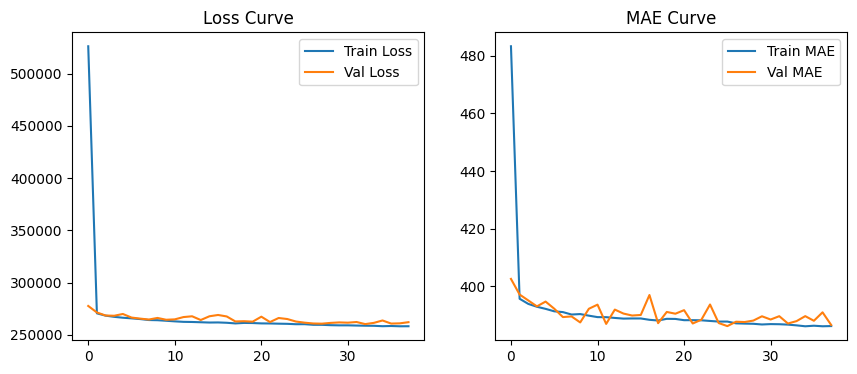

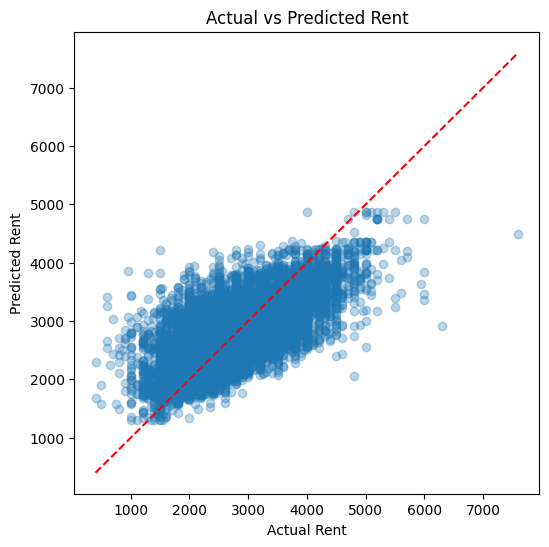

Random Forest MAE: 387.49
XGBoost MAE: 380.05


In [10]:
"""
Deep Learning Capstone: Multi-Input Rental Price Predictor
Comprehensive Template
"""

!pip install xgboost
!pip install geopy
!pip install tensorflow

# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from geopy.distance import geodesic
from scipy.spatial.distance import cdist
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 2. Load Datasets
def load_data():
    flats = pd.read_csv('RentingOutofFlats2025.csv')
    income = pd.read_csv('monthly household income.csv')
    mrt = pd.read_csv('mrt_station.csv')
    return flats, income, mrt


flats, income, mrt = load_data() # Load your data

# Check for missing values in latitude and longitude
print(flats[['latitude', 'longitude']].isnull().sum())

# 3. Data Preprocessing & Feature Engineering
def preprocess_and_engineer(flats, income, mrt):
    # --- Temporal Features ---
    flats['rent_approval_date'] = pd.to_datetime(flats['rent_approval_date'], errors='coerce')
    flats['approval_year'] = flats['rent_approval_date'].dt.year
    flats['approval_month'] = flats['rent_approval_date'].dt.month

    # --- Merge Income (by year) ---
    flats = flats.merge(income.rename(columns={'year': 'approval_year'}), on='approval_year', how='left')

    # --- MRT Proximity ---
    # Compute distance to nearest MRT for each flat
    def nearest_mrt_distance(row):  # Changed to accept a row
        #"""Calculates the distance to the nearest MRT station for each flat."""
        if pd.isnull(row['latitude']) or pd.isnull(row['longitude']):
            return np.nan # Handle missing coordinates

        flat_coords = (row['latitude'], row['longitude'])
        mrt_coords = mrt[['latitude', 'longitude']].values

        # Calculate distances using cdist (more efficient than looping)
        distances = cdist([flat_coords], mrt_coords, metric='euclidean')

        # Get the minimum distance
        nearest_distance = np.min(distances)

        return nearest_distance

    # Apply the nearest_mrt_distance function to the dataframe
    flats['nearest_mrt_dist'] = flats.apply(nearest_mrt_distance, axis=1)

    # --- Add mrt_within_1km column ---
    flats['mrt_within_1km'] = (flats['nearest_mrt_dist'] <= 1).astype(int) # Create mrt_within_1km column

    # --- Handle Categorical and Missing Values ---
    # Fill missing for income
    flats['average'] = flats['average'].fillna(flats['average'].median())
    flats['medium'] = flats['medium'].fillna(flats['medium'].median())
    # Fill missing for rent
    flats = flats[~flats['monthly_rent'].isna()]

    return flats

# 4. Prepare Features
def prepare_features(flats):
    # Features to use
    categorical_cols = ['flat_type', 'region', 'town']
    numerical_cols = ['latitude', 'longitude', 'approval_year', 'approval_month',
                      'average', 'medium', 'nearest_mrt_dist', 'mrt_within_1km']
    target_col = 'monthly_rent'

    X = flats[categorical_cols + numerical_cols]
    y = flats[target_col]

    # Preprocessing pipelines
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer([
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

    return X, y, preprocessor

# 5. Data Split
def split_data(X, y, test_size=0.2, val_size=0.1, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size+val_size, random_state=random_state)
    val_ratio = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

# 6. Build Deep Learning Model
def build_mlp_model(input_shape):
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)  # Regression output
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

# 7. Model Training
def train_dl_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=2
    )
    return model, history

# 8. Model Evaluation
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")
    return {'mae': mae, 'rmse': rmse, 'r2': r2}, preds

# 9. Baseline Comparison
def train_baseline_models(X_train, y_train, X_val, y_val, X_test, y_test):
    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)
    rf_mae = mean_absolute_error(y_test, rf_preds)

    # XGBoost
    xgb = XGBRegressor(n_estimators=100, random_state=42)
    xgb.fit(X_train, y_train)
    xgb_preds = xgb.predict(X_test)
    xgb_mae = mean_absolute_error(y_test, xgb_preds)

    print(f"Random Forest MAE: {rf_mae:.2f}")
    print(f"XGBoost MAE: {xgb_mae:.2f}")
    return {'rf': rf_mae, 'xgb': xgb_mae}

# 10. Visualization & Reporting
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('MAE Curve')
    plt.legend()
    plt.show()

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.xlabel('Actual Rent')
    plt.ylabel('Predicted Rent')
    plt.title('Actual vs Predicted Rent')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.show()

# 11. Save Model & Artifacts
def save_model(model, preprocessor, model_path='mlp_model.h5', prep_path='preprocessor.pkl'):
    model.save(model_path)
    import joblib
    joblib.dump(preprocessor, prep_path)

# 12. Main Execution
if __name__ == '__main__':
    # Load data
    flats, income, mrt = load_data()

    # Preprocess and feature engineering
    flats = preprocess_and_engineer(flats, income, mrt)

    # Prepare features
    X, y, preprocessor = prepare_features(flats)
    X_processed = preprocessor.fit_transform(X)

    # Split data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_processed, y)

    # Build and train DL model
    model = build_mlp_model(input_shape=(X_train.shape[1],)) # Pass input_shape as a tuple
    model, history = train_dl_model(model, X_train, y_train, X_val, y_val)

    # Evaluate DL model
    metrics, preds = evaluate_model(model, X_test, y_test)
    plot_history(history)
    plot_predictions(y_test, preds)

    # Baseline comparison
    train_baseline_models(X_train, y_train, X_val, y_val, X_test, y_test)

    # Save model and preprocessor
    save_model(model, preprocessor)